In [1]:
# Loading the required packages
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import *
import pretrainedmodels
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
from utils import *
import sys

In [2]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import csv
import pandas as pd
import os,sys
#import tensorflow as tf
from numpy import linalg as LA
from typing import Callable

In [3]:
# Main Path
path_main=Path('/home/visionlab/Georgin/algonautsChallenge_codes/')

In [4]:
# All paths relative to main paths
path_training_image_pairs=Path(path_main/'Training_Data/210_imagepairs/')
path_training_csv_set1=Path(path_main/'Training_Data/92_Image_Set/')
path_training_csv_set2=Path(path_main/'Training_Data/118_Image_Set/')

In [5]:
# select early or late response using this flag_EL
# Early=1, Late=2
flag_EL=1
# select fmRI or MEG using this flag
flag_FM=1 # 1 for MEG and 2 for Fmri 

In [6]:
# Training the DATA
df_set1 = pd.read_csv(path_training_csv_set1/'set1_training_distance_file.csv'); 
df_set2=pd.read_csv(path_training_csv_set2/'set2_training_distance_file.csv')
df=pd.concat([df_set1.loc[0:92*91-1],df_set2.loc[0:118*117-1]], ignore_index=True)# removed the identical pairs
#df=pd.concat([df_set1,df_set2], ignore_index=True)# removed the identical pairs
df.head()

,ImagePair,earlyDistance,lateDistance,fmri_evc,fmri_it
0,set92_image_01_image_02.jpg,0.374229,0.557752,0.651895,0.438132
1,set92_image_01_image_03.jpg,0.368932,0.439496,0.626384,0.395722
2,set92_image_01_image_04.jpg,0.463916,0.524331,0.627330,0.416473
3,set92_image_01_image_05.jpg,0.666419,0.518694,0.736833,0.454702
4,set92_image_01_image_06.jpg,0.421931,0.490629,0.644696,0.415026


In [7]:
# normlization values of mean and std taken from ImageNet
mean, std = torch.tensor(imagenet_stats)

In [8]:
# Custom Data bunch
# Creating the data bunch by concatenating two image together after normalizaing the images separately. 
# Size of the image is fixed to 175x175
class SiamImage(ItemBase):
    def __init__(self, img1, img2): ## These should of Image type
        self.img1, self.img2 = img1, img2
        self.obj, self.data = (img1, img2), [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'
    def to_one(self):
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])
    
    
    
class SiamImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self._label_cls=FloatList
    
    def __len__(self)->int: return len(self.items) or 1 
    
    def get(self, i):
        img1=super().get(i)
        crop(img1,175,*[0.0,0.0])
        img2=super().get(i) 
        crop(img2,175,*[0.0,1.0])
        return SiamImage(img1, img2)
    def reconstruct(self, t): return SiamImage(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None])
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [9]:
# Preparing the data
whl_tfms=get_transforms(do_flip=False,max_rotate=0.0,max_warp=0.0)
bs =64
# early data/Late
# flag_EL decides by selecting diffrent columns
data = (SiamImageItemList.from_df(df=df, path=path_training_image_pairs, cols=0)
         .split_by_rand_pct(valid_pct=0.005, seed=34)
         .label_from_df(cols=flag_EL, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=bs))

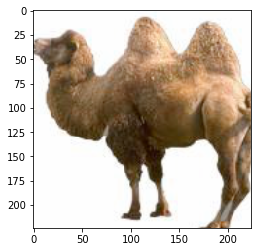

In [10]:
# Checking if the normalization done above is correct
x = next(iter(data.train_dl))
t=x[0][0][0].cpu()
to = mean[...,None,None] + t* std[...,None,None]
import torchvision
ti = torchvision.transforms.ToPILImage(to)
plt.imshow(to.numpy().transpose(1,2,0))

In [11]:
def alexnet_ITmodel(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.alexnet(pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers[1])

In [12]:
# alternate model
# DNN training Model
from fastai.vision import learner
from numpy import linalg as LA
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.body = alexnet_ITmodel()
        self.groupconv=nn.Sequential(
                       nn. Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=256),
                       nn.ReLU(),
                       nn.AvgPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=False     ))
        self.distance=nn.Linear(1024,1)
    def forward(self, x1, x2):
       # pdb.set_trace();
        output1 = self.body(x1) 
        output2 = self.body(x2)
        out=torch.stack((output1,output2),dim=2)
        out=out.reshape([ output1.shape[0],output1.shape[1]*2,output1.shape[2],output1.shape[3]])
        out=self.groupconv(out)
        out = out.view(out.size()[0], -1)
        dist=self.distance(out)
        dist=torch.relu(dist)
       # output  = torch.sigmoid(dist)
        return dist

    def get_embedding(self, x1,x2):
       # pdb.set_trace();
        output1 = self.body(x1) 
        output2 = self.body(x2)
        out=torch.stack((output1,output2),dim=2)
        out=out.reshape([ output1.shape[0],output1.shape[1]*2,output1.shape[2],output1.shape[3]])
        out=self.groupconv(out)
        out = out.view(out.size()[0], -1)
        dist=self.distance(out)
        dist=torch.relu(dist)
       # output  = torch.sigmoid(dist)
        return dist

In [13]:
import pdb;

In [14]:
# Learner
model = SiameseNet().cuda()
#apply_init(model.head, nn.init.kaiming_normal_)
#loss_func=ContrastiveLoss().cuda()
siam_learner = Learner(data, model,metrics=explained_variance)

In [15]:
model

SiameseNet(
  (body): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (groupconv): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256)
    (1): ReLU()
    (2): AvgPool2d(kernel_size=3, stride=2, padding=

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


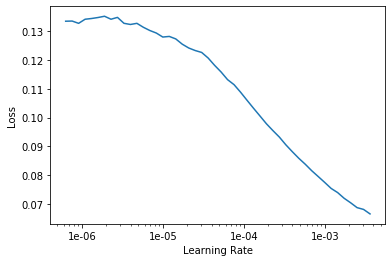

In [16]:
siam_learner.lr_find()
siam_learner.recorder.plot()

In [17]:
if(flag_EL==1):
    path_model=Path(path_main/'train_models/alexnet/evc')
if(flag_EL==2):
    path_model=Path(path_main/'train_models/alexnet/it')
epoch_count=0

In [18]:
EpochMax=10
Lmax=8*1e-4
cycle_per_lr=1
LR=[round(Lmax*(1-(epoch/EpochMax)),5) for epoch in range(1,EpochMax)]
print(LR)

[0.00072, 0.00064, 0.00056, 0.00048, 0.0004, 0.00032, 0.00024, 0.00016, 8e-05]


In [ ]:
for lr in LR:
    siam_learner.fit_one_cycle(cycle_per_lr,lr)
    epoch_count+=cycle_per_lr
    name='evc_epoch='+str(epoch_count)+'learning_rate='+str(lr)
    siam_learner.save(path_model/name)

epoch,train_loss,valid_loss,explained_variance,time
0,0.001753,0.001835,0.773585,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.001283,0.000923,0.882365,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.001045,0.000787,0.904613,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000868,0.000688,0.913821,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000760,0.000601,0.927966,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000635,0.000537,0.934594,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000546,0.000482,0.940771,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000499,0.000451,0.945839,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000442,0.000377,0.953469,00:34


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


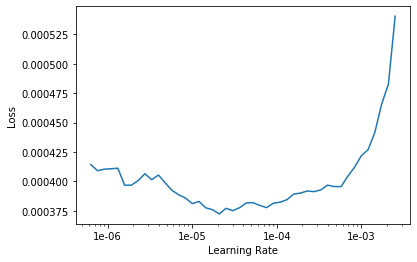

In [ ]:
siam_learner.lr_find()
siam_learner.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


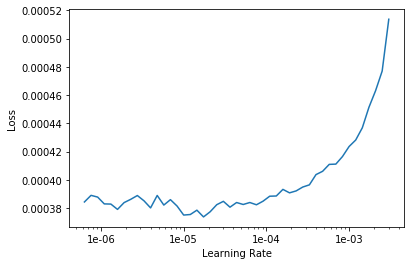

In [ ]:
# Unfreezing last convolutional lay
siam_learner.unfreeze
siam_learner.lr_find()
siam_learner.recorder.plot()

In [ ]:
#EpochMax=500
EpochMax=200
Lmax=2*1e-5
cycle_per_lr=1
LR=[round(Lmax*(1-(epoch/EpochMax)),10) for epoch in range(1,EpochMax)]

In [ ]:
for lr in LR:
    siam_learner.fit_one_cycle(cycle_per_lr,lr)
    epoch_count+=cycle_per_lr
    name='evc_epoch='+str(epoch_count)+'learning_rate='+str(lr)
    siam_learner.save(path_model/name)

epoch,train_loss,valid_loss,explained_variance,time
0,0.000405,0.000392,0.952966,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000391,0.000401,0.951813,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000371,0.000386,0.953704,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000379,0.000383,0.954024,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000372,0.000386,0.953307,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000364,0.000393,0.952522,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000358,0.000369,0.955390,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000360,0.000351,0.957345,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000341,0.000351,0.957052,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000340,0.000364,0.956092,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000342,0.000360,0.956410,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000338,0.000371,0.955645,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000330,0.000367,0.956036,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000328,0.000348,0.958283,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000330,0.000337,0.959747,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000330,0.000347,0.958645,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000317,0.000339,0.959598,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000316,0.000341,0.959582,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000312,0.000355,0.958284,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000305,0.000323,0.961349,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000307,0.000320,0.962279,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000304,0.000331,0.960909,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000303,0.000337,0.960503,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000298,0.000321,0.962162,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000290,0.000313,0.962605,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000283,0.000320,0.962812,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000286,0.000328,0.961317,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000285,0.000309,0.964574,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000286,0.000334,0.961319,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000285,0.000323,0.962917,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000281,0.000322,0.962870,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000279,0.000318,0.962981,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000271,0.000320,0.963061,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000265,0.000327,0.962230,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000273,0.000313,0.963787,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000263,0.000318,0.963618,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000260,0.000310,0.963338,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000277,0.000324,0.962815,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000261,0.000302,0.965021,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000256,0.000307,0.964141,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000261,0.000308,0.964306,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000261,0.000303,0.965047,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000253,0.000305,0.964649,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000253,0.000300,0.965081,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000252,0.000299,0.965248,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000247,0.000291,0.966062,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000245,0.000314,0.963485,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000238,0.000304,0.965363,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000240,0.000301,0.965052,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000236,0.000295,0.966015,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000239,0.000308,0.964589,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000240,0.000310,0.963935,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000232,0.000284,0.967208,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000239,0.000287,0.967072,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000239,0.000282,0.967030,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000232,0.000296,0.965766,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000235,0.000303,0.964681,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000226,0.000291,0.965732,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000228,0.000285,0.967252,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000228,0.000298,0.965723,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000222,0.000293,0.966756,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000217,0.000297,0.966235,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000221,0.000284,0.967094,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000224,0.000275,0.968236,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000219,0.000277,0.967155,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000215,0.000275,0.967885,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000216,0.000281,0.967318,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000211,0.000272,0.968207,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000218,0.000276,0.968190,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000213,0.000276,0.967905,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000213,0.000282,0.967462,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000212,0.000268,0.968582,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000217,0.000271,0.968381,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000212,0.000261,0.969347,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000205,0.000262,0.969977,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000205,0.000277,0.968714,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000213,0.000269,0.968994,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000202,0.000271,0.968593,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000197,0.000263,0.969221,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000200,0.000258,0.969726,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000199,0.000269,0.968746,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000197,0.000266,0.969030,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000198,0.000268,0.969180,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000200,0.000269,0.968862,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000198,0.000268,0.968788,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000193,0.000264,0.969160,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000199,0.000267,0.969072,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000194,0.000258,0.970455,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000188,0.000261,0.970018,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000191,0.000261,0.969442,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000195,0.000265,0.969310,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000186,0.000252,0.970633,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000186,0.000265,0.969585,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000186,0.000260,0.970600,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000191,0.000255,0.970310,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000184,0.000244,0.971608,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000185,0.000257,0.970234,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000186,0.000255,0.970690,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000180,0.000241,0.971758,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000185,0.000248,0.970831,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000178,0.000253,0.970296,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000184,0.000261,0.968994,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000178,0.000250,0.970419,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000183,0.000243,0.970931,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000179,0.000238,0.971647,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000180,0.000240,0.971434,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000177,0.000251,0.970442,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000178,0.000246,0.970903,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000180,0.000252,0.970278,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000177,0.000246,0.970648,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000174,0.000242,0.971857,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000178,0.000242,0.971059,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000178,0.000250,0.970332,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000174,0.000255,0.970666,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000170,0.000243,0.971457,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000175,0.000236,0.972160,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000171,0.000241,0.971768,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000170,0.000237,0.972036,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000170,0.000237,0.972005,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000165,0.000245,0.971548,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000168,0.000238,0.972095,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000167,0.000234,0.972554,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000167,0.000242,0.971705,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000167,0.000228,0.973514,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000168,0.000231,0.972823,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000166,0.000229,0.973171,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000163,0.000234,0.972918,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000169,0.000225,0.973499,00:34


epoch,train_loss,valid_loss,explained_variance,time
0,0.000171,0.000234,0.972679,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000161,0.000232,0.972922,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000160,0.000230,0.973064,00:36


epoch,train_loss,valid_loss,explained_variance,time
0,0.000164,0.000233,0.972648,00:35


epoch,train_loss,valid_loss,explained_variance,time
0,0.000162,0.000236,0.972265,00:35


epoch,train_loss,valid_loss,explained_variance,time


In [ ]:
# Initializing the Matlibplot
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

In [ ]:
# Finding the correlation observed and predicted correlational distance
dl=data.train_dl
ds=data.train_ds
dlv=data.valid_dl
dsv=data.valid_ds
x=siam_learner.get_preds(dlv)
preds=x[0].numpy()
areds=x[1].numpy()

plt.scatter(preds,areds)
plt.xlabel('predicted distance')
plt.ylabel('observed distance')
plt.title('Training Data, set1 and set2')
plt.show()
model_correlation=np.corrcoef(preds.transpose(),areds)[0][1]
print('Correlation between observed and Predicted =',model_correlation)

In [ ]:
# Extracting the distance from last layer
# This is done by creating image pair using test and and finding the distance from the last layer

In [ ]:
path_test_file=Path(path_main/'Test_Data')
path_test_image_pairs=Path(path_main/'Test_Data/78images/')

In [ ]:
image_file_names=os.listdir(path_test_file/'78images_imagepairs')
image_file_names=np.sort(image_file_names)
image_file_names=image_file_names.tolist()

In [ ]:
df_test = pd.read_csv(path_test_file/'testset_testing_distance_file.csv')
df_test.head()

In [ ]:
data_test = (SiamImageItemList.from_df(df=df_test, path=path_test_image_pairs, cols=0)
         .random_split_by_pct(valid_pct=1, seed=34)
         .label_from_df(cols=1, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=bs))

In [ ]:
def extract_embedding_test(dl, ds, mdl):
    mdl.eval()
    with torch.no_grad():
        #preds = torch.zeros((len(ds), 1))
        #areds = torch.zeros(1,(len(ds)))
        preds=np.zeros((len(ds),1))
        areds=np.zeros((len(ds),1))
        start=0
        for cnt, (x, y) in enumerate(dl, start=0):
            size = x[0].shape[0]
            index=y.cpu()
            index=index.numpy().astype(int)
           # pdb.set_trace();
            value=model.get_embedding(x[0],x[1])
            #index=list(range(cnt+))
            preds[index] =value.cpu().numpy()
            start+= size
        return preds

In [ ]:
dlt=data_test.valid_dl
dst=data_test.valid_ds
preds = extract_embedding_test(dlt,dst, model)
preds=preds.squeeze()

In [ ]:
# Creating the RDMs of 78 image test set 
from itertools import combinations
N=78
RDM=np.zeros([N,N])
combAB = combinations(range(0,N),2)
combAB=list(combAB)
Nc=len(combAB)
count=0
for ij in combAB:
    i=ij[0]
    j=ij[1]
    RDM[i][j] = preds[count]
    RDM[j][i]=  RDM[i][j]
    count=count+1;

In [ ]:
import scipy.io as sio
if(flag_EL==1):
    sio.savemat(path_test_image_pairs/'../RDM_EVS_groupConv_res_18_ver8.mat', {'evs':RDM})
if(flag_EL==2):
    sio.savemat(path_test_image_pairs/'../RDM_IT_groupConv_res_18_ver8mat', {'it':RDM}) 
plt.matshow(RDM);    

In [ ]:
# After submitting the models we found that the last layers were not giving the best solutions
# Hence we took the intermediate layer features and got the distance from it. 

In [ ]:
# this set has 78 images identical
path_test_image_pairs_combined=Path(path_main/'Test_Data/78images_combined')

In [ ]:
image_file_names=os.listdir(path_test_image_pairs_combined)
image_file_names=np.sort(image_file_names)
image_file_names=image_file_names.tolist()

In [ ]:
test_cond=[]
count=0
for i in image_file_names:
    one=['','']
    one[0]=i
    one[1]=count
    count=count+1
    test_cond.append(one)
df_test_identical=DataFrame(test_cond,columns=['Image Pairs','Count'])

In [ ]:
data_test_identical = (SiamImageItemList.from_df(df=df_test_identical, path=path_test_image_pairs_combined, cols=0)
         .random_split_by_pct(valid_pct=1, seed=34)
         .label_from_df(cols=1, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=bs))

In [ ]:
# Feature Extraction from the trained model
class SaveFeatures:
    def __init__(self, m):
        self.handle = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, m, inp, outp):
        self.features = outp
    def remove(self):
        self.handle.remove()
mdl=siam_learner.model

In [ ]:
mdl.body

In [ ]:
# defining the layers 
sf = [SaveFeatures(m) for m in [mdl.body[12]]]

In [ ]:
Predicted_Features=np.zeros((len( data_test_identical.valid_ds.x),9216))
for i in range(0,len(data_test_identical.valid_ds.x)):
    #pdb.set_trace()
    img1 = data_test_identical.valid_ds.x[i]
    ind=data_test_identical.valid_ds.y[i]
    ind=int(float(str(ind)))
    siam_learner.predict(img1)
    #
    Feat_oneimage=[o.features.cpu().numpy() for o in sf]
    Feat_oneimage=Feat_oneimage[0][0]
    Feat_oneimage=np.reshape(Feat_oneimage,(np.size(Feat_oneimage),1))
    #pdb.set_trace()
    Predicted_Features[ind][:]=Feat_oneimage.squeeze()

In [ ]:
# Creating the RDMS of the test set of 78images 
from itertools import combinations
N=78
RDM_corr=np.zeros([N,N])
combAB = combinations(range(0,N),2)
combAB=list(combAB)
Nc=len(combAB)
count=0
for ij in combAB:
    i=ij[0]
    j=ij[1]
    RDM_corr[i][j] = 1-np.corrcoef(Predicted_Features[i][:],Predicted_Features[j][:])[0][1]
    RDM_corr[j][i]=  RDM_corr[i][j]
    count=count+1;

In [ ]:
plt.matshow(RDM_corr);  

In [ ]:
import scipy.io as sio
if(flag_EL==1):
    sio.savemat(path_test_image_pairs/'../RDM_EVS_layer_12_res_18_ver5.mat', {'evs':RDM_corr})
if(flag_EL==2):
    sio.savemat(path_test_image_pairs/'../RDM_IT_layer_12_res_18_ver5.mat', {'it':RDM_corr}) 
plt.matshow(RDM_corr);    